# Behavioral Metrics Exploration

Use this notebook to explore the behavioral metrics and lineage statistics captured during a simulation run. Adjust the file paths if you save logs elsewhere.

In [1]:
import json
import numpy as np
from pathlib import Path

# Define paths
logs_dir = Path("../experiments/logs")
metrics_path = logs_dir / "metrics.npz"
lineage_stats_path = logs_dir / "lineage_stats.json"

# Load NumPy metrics file
if metrics_path.exists():
    metrics = np.load(metrics_path)
    print(f"Loaded metrics keys: {list(metrics.keys())[:10]} ...")
else:
    print(f"Metrics file not found: {metrics_path}")
    metrics = None

# Load JSON lineage stats file
if lineage_stats_path.exists():
    lineage_stats = json.loads(lineage_stats_path.read_text())
    
    # Handle both dict and list cases
    if isinstance(lineage_stats, dict):
        print(f"Loaded lineage stats keys: {list(lineage_stats.keys())[:10]} ...")
    elif isinstance(lineage_stats, list):
        print(f"Loaded lineage stats as list with {len(lineage_stats)} items")
        if len(lineage_stats) > 0:
            print(f"First item preview: {lineage_stats[0]}")
    else:
        print(f"Loaded lineage stats type: {type(lineage_stats)}")
else:
    print(f"Lineage stats file not found: {lineage_stats_path}")
    lineage_stats = None

Loaded metrics keys: ['timesteps', 'population', 'births', 'deaths', 'mean_energy', 'mean_age', 'max_age', 'total_food', 'mean_distance_per_step', 'std_distance_per_step'] ...
Loaded lineage stats as list with 11 items
First item preview: {'timestep': 0, 'total_agents': 50, 'active_lineages': 50, 'extinct_lineages': 0, 'dominant_lineages': [{'founder_id': 0, 'descendants': 1, 'percentage': 2.0}, {'founder_id': 1, 'descendants': 1, 'percentage': 2.0}, {'founder_id': 2, 'descendants': 1, 'percentage': 2.0}, {'founder_id': 3, 'descendants': 1, 'percentage': 2.0}, {'founder_id': 4, 'descendants': 1, 'percentage': 2.0}], 'lineage_diversity_index': 0.98, 'mean_generation': 0.0, 'max_generation': 0, 'descendants_per_founder': {'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '10': 1, '11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '16': 1, '17': 1, '18': 1, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 1, '27': 1, '28': 1, '29': 1, '30': 1, '

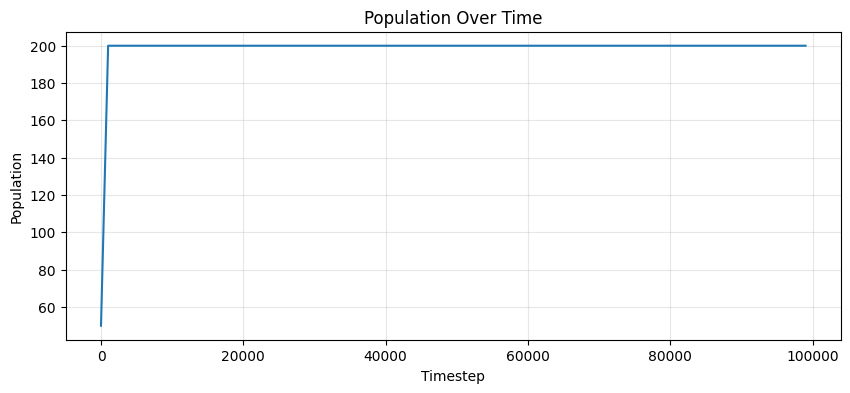

In [2]:
import matplotlib.pyplot as plt

if metrics is not None:
    population = metrics['population']
    timesteps = metrics['timesteps']
    plt.figure(figsize=(10, 4))
    plt.plot(timesteps, population, color='tab:blue')
    plt.title('Population Over Time')
    plt.xlabel('Timestep')
    plt.ylabel('Population')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print('Metrics data not loaded; run a simulation first.')


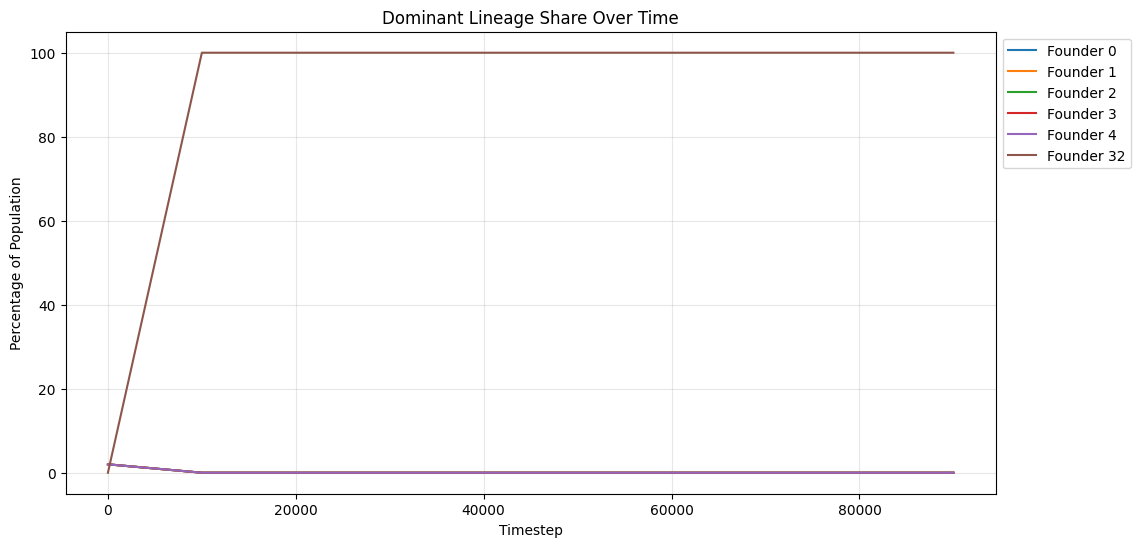

In [3]:
import matplotlib.pyplot as plt

if lineage_stats:
    import pandas as pd
    if isinstance(lineage_stats, list):
        df = pd.DataFrame(lineage_stats)
    else:
        df = pd.DataFrame([lineage_stats])

    if 'dominant_lineages' in df.columns and 'timestep' in df.columns:
        rows = []
        for _, row in df.iterrows():
            timestep = row['timestep']
            lineages = row['dominant_lineages'] or []
            for entry in lineages:
                rows.append({
                    'timestep': timestep,
                    'founder_id': entry.get('founder_id'),
                    'descendants': entry.get('descendants', 0),
                    'percentage': entry.get('percentage', 0.0)
                })
        if rows:
            dom_df = pd.DataFrame(rows)
            pivot = dom_df.pivot_table(index='timestep', columns='founder_id', values='percentage', fill_value=0.0)
            pivot.sort_index(inplace=True)
            plt.figure(figsize=(12, 6))
            for founder_id in pivot.columns:
                plt.plot(pivot.index, pivot[founder_id], label=f'Founder {founder_id}')
            plt.title('Dominant Lineage Share Over Time')
            plt.xlabel('Timestep')
            plt.ylabel('Percentage of Population')
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
            plt.grid(alpha=0.3)
            plt.show()
        else:
            print('Dominant lineage entries are empty.')
    else:
        print('Dominant lineage data not present in lineage stats.')
else:
    print('Lineage stats data not loaded; run a simulation first.')


In [4]:
import sys
from pathlib import Path

project_root = Path('..').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.analysis import open_lineage_database
import pandas as pd

FOUNDER_ID = 7  # change as needed

if 'logs_dir' not in globals():
    print('logs_dir not defined; run the earlier cell first.')
else:
    try:
        conn = open_lineage_database(logs_dir)
    except FileNotFoundError:
        conn = None
        print(f"Lineage database not found in {logs_dir}")
    if conn is not None:
        query = """WITH RECURSIVE descendants(id, parent_id, root_id, generation, death) AS (
        SELECT id, parent_id, root_id, generation, death
        FROM agents
        WHERE root_id = ?
        UNION
        SELECT a.id, a.parent_id, a.root_id, a.generation, a.death
        FROM agents a
        JOIN descendants d ON a.parent_id = d.id
    )
    SELECT id, parent_id, generation, (death IS NULL) AS is_alive
    FROM descendants
    ORDER BY generation, id;"""
        cursor = conn.execute(query, (FOUNDER_ID,))
        rows = cursor.fetchall()
        conn.close()
        if rows:
            df_desc = pd.DataFrame(rows, columns=['id', 'parent_id', 'generation', 'is_alive'])
            display(df_desc)
            alive_count = int(df_desc['is_alive'].sum())
            print(f"Total descendants: {len(df_desc)} (alive: {alive_count}, dead: {len(df_desc) - alive_count})")
        else:
            print(f"No descendants found for founder {FOUNDER_ID}.")


,id,parent_id,generation,is_alive
0,7,NaN,0,0
1,52,7.0,1,0
2,185,7.0,1,0
3,72,52.0,2,0
4,118,52.0,2,0
...,...,...,...,...
81,1864,1756.0,16,0
82,2001,1851.0,16,0
83,1986,1864.0,17,0
84,2148,2001.0,17,0


Total descendants: 86 (alive: 0, dead: 86)


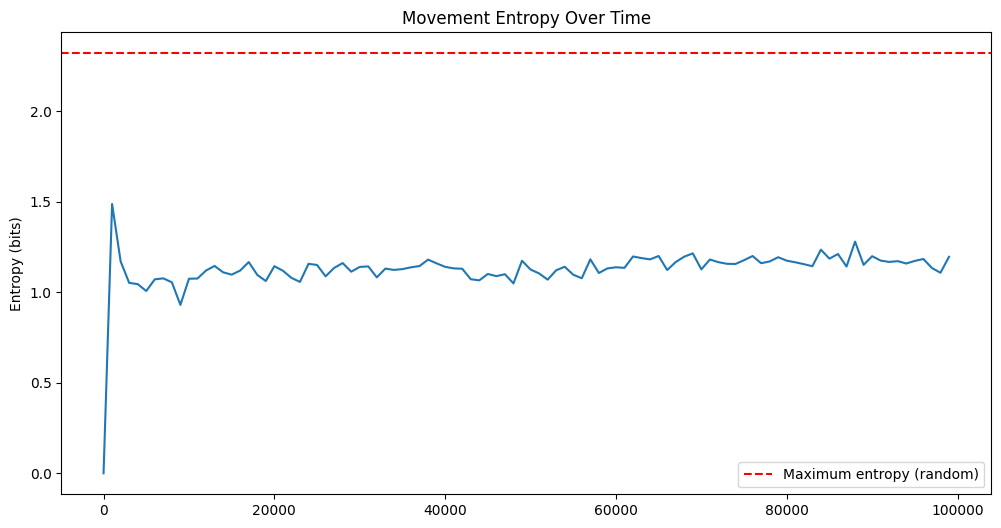

In [9]:
if metrics is not None:
    # Movement entropy: High = random, Low = patterned
    timesteps = metrics['timesteps']
    mean_movement_entropy = metrics['mean_movement_entropy']
    plt.figure(figsize=(12, 6))
    plt.plot(timesteps, mean_movement_entropy, color='tab:blue')
    plt.axhline(2.32, color='r', linestyle='--', 
                label='Maximum entropy (random)')
    plt.title('Movement Entropy Over Time')
    plt.ylabel('Entropy (bits)')
    plt.legend()
else:
    print('Metrics data not loaded; run a simulation first.')